# Step 3: Optimization with uncertain conversion rates

In [1]:
# fixed graph weights (same click influence probabilities between the products for each user)
# homogeneous users (one class with small variability)
# fixed alphas (same number of users each day distributed equally between the initial webpages)
# uncertain conversion rates

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from Environment.E_commerce import *
from Algorithms.Conv_rates_Learner import *
from Algorithms.Greedy_Learner import *
from Algorithms.TS_Learner import *
from Algorithms.UCB_Learner import *

In [3]:
P1 = Product(0,[19.99, 21.99, 23.99, 26.99],np.multiply([0.2, 0.2, 0.2, 0.2],[19.99, 19.99, 19.99, 19.99])+[0, 21.99-19.99, 23.99-19.99, 26.99-19.99])
# t-shirt
P2 = Product(1,[29.99, 32.59, 35.99, 39.99],np.multiply([0.2, 0.2, 0.2, 0.2],[29.99, 29.99, 29.99, 29.99])+[29.99, 32.59, 35.99, 39.99]-29.99)
# shirt
P3 = Product(2,[25.99,28.99, 31.99, 34.99],np.multiply([0.3, 0.3, 0.3, 0.3],[25.99,25.99, 25.99, 25.99])+[25.99,28.99, 31.99, 34.99]-25.99)
# shorts
P4 = Product(3,[38.99,43.99,46.99, 49.99],np.multiply([0.4, 0.4, 0.4, 0.4],[38.99,38.99,38.99, 38.99])+[38.99,43.99,46.99, 49.99]-38.99)
# pants
P5 = Product(4,[79.99,89.99, 99.99, 109.99],np.multiply([0.5, 0.5, 0.5, 0.5],[79.99,79.99, 79.99, 79.99])+[79.99,89.99, 99.99, 109.99]-79.99)
# shoes

products = [P1,P2,P3,P4,P5]
margins_matrix = np.zeros((5,4))
for i in range(5):
    for j in range(4):
        margins_matrix[i,j] = products[i].margins_list[j]
print("Margin matrix: ")
print(margins_matrix)

E = E_commerce()
E.graph = np.array([[0. , 0., 1. , 0.5 , 0. ],[0. , 0. , 0.5 , 1., 0. ],[0.5 , 1. , 0. , 0. , 0. ],[1. , 0.5 , 0. , 0. , 0. ],[0. , 0.5 , 0. , 1. , 0. ]])
E.set_products(products)
E.set_lambda(0.5)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]


Using a simple algorithm trained for a long time (1000 days, repeated 10 times), we obtain an estimation of conversion rates and expected rewards of the arms for each product. This will be considered our clairvoyant solution.

In [6]:
# Random algorithm which for each round pulls a random choice
# to estimate asymptotically the conv_rates and the mean of the number of units sold per product,
# useful for computing clairvoyant solution and regrets of the bandit algorithms


n_arms = 4
num_users = 100 #mean number of users for each day
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
num_experiments = 3
opt_vector = np.zeros(num_experiments)
conv_rates_per_experiment = []
mean_units_sold_per_product_per_experiment = []
cr_learner_expected_rewards_per_experiment = []

for e in range(num_experiments):
    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights,fixed_units)
    cr_learner = Conv_rates(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = cr_learner.pull_arm()
        reward = env.round(pulled_arm)
        cr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day,env.daily_units)


    conversion_rates = np.zeros((5,4))
    np.set_printoptions(suppress=True)
    for i in range(5):
        conversion_rates[i] = cr_learner.beta_parameters[i][:,0]/(cr_learner.beta_parameters[i][:,0]+cr_learner.beta_parameters[i][:,1])
        opt_vector[e] += np.max(np.array(E.products[i].margins_list) * conversion_rates[i] * cr_learner.lambda_poisson[i])

    conv_rates_per_experiment.append(conversion_rates)
    mean_units_sold_per_product_per_experiment.append(cr_learner.lambda_poisson)
    cr_learner_expected_rewards_per_experiment.append(cr_learner.expected_rewards)

#optimal expected clarvoyant solution is given choosing each round the best combination
opt = np.mean(opt_vector) #+ np.std(opt_vector)
best_arm_per_product = np.zeros(5)
for i in range(5):   
    best_arm_per_product[i] = np.argmax(np.array(E.products[i].margins_list) * np.mean(conv_rates_per_experiment,axis=0)[i]
                                        * np.mean(mean_units_sold_per_product_per_experiment, axis = 0)[i])#expected_units_sold_per_product[i])#
    
print("_______________________________________________")
print("Conversion rates")
print(np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Rewards per arm of this simple algorithm")
print(np.mean(cr_learner_expected_rewards_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate")
print(margins_matrix*np.mean(conv_rates_per_experiment,axis=0))
print("_______________________________________________")
print("Expected units sold per arm")
print(np.mean(mean_units_sold_per_product_per_experiment, axis = 0))

print("_______________________________________________")
print("Best configuration", best_arm_per_product)
print("Optimal cumulative expected reward per round")
print(opt) # optimal configuration: the best combination of arms


_______________________________________________
Conversion rates
[[0.90551703 0.56887809 0.15521339 0.0016859 ]
 [0.90507556 0.61975384 0.12023611 0.00098213]
 [0.96253833 0.69193208 0.17993197 0.00523546]
 [0.96783148 0.6676777  0.29265542 0.05327914]
 [0.99721177 0.74476129 0.41508432 0.02128955]]
_______________________________________________
Rewards per arm of this simple algorithm
[[ 7.24044958  6.82470983  2.47410553  0.03317746]
 [ 5.42494451  5.31966444  1.45203513  0.01310909]
 [22.51271045 22.38830959  7.41597572  0.24975812]
 [45.28894191 41.15109769 20.70617165  4.25050372]
 [39.88984425 37.23996483 24.88280663  1.47241057]]
Expected rewards per arm = margin * conversion rate
[[ 3.6202571   3.41213077  1.24139666  0.01854155]
 [ 5.42864321  5.32864354  1.44259288  0.01571213]
 [ 7.50491136  7.47079065  2.48252145  0.08794009]
 [15.09429975 13.75148984  6.90549734  1.41701202]
 [39.88348494 37.23434078 24.9029835   1.49016176]]
______________________________________________

In [89]:
opt

137.00594862647534

## Thompson Sampling: optimization of the cumulative expected margin over all the products

In [7]:
print("Margin matrix: ")
print(margins_matrix)
print("Estimated conversion rates: ")
print(np.mean(conv_rates_per_experiment,axis=0))
print("Expected rewards per arm = margin * conversion rate ")
print(np.mean(conv_rates_per_experiment,axis=0)*margins_matrix)

Margin matrix: 
[[ 3.998  5.998  7.998 10.998]
 [ 5.998  8.598 11.998 15.998]
 [ 7.797 10.797 13.797 16.797]
 [15.596 20.596 23.596 26.596]
 [39.995 49.995 59.995 69.995]]
Estimated conversion rates: 
[[0.90551703 0.56887809 0.15521339 0.0016859 ]
 [0.90507556 0.61975384 0.12023611 0.00098213]
 [0.96253833 0.69193208 0.17993197 0.00523546]
 [0.96783148 0.6676777  0.29265542 0.05327914]
 [0.99721177 0.74476129 0.41508432 0.02128955]]
Expected rewards per arm = margin * conversion rate 
[[ 3.6202571   3.41213077  1.24139666  0.01854155]
 [ 5.42864321  5.32864354  1.44259288  0.01571213]
 [ 7.50491136  7.47079065  2.48252145  0.08794009]
 [15.09429975 13.75148984  6.90549734  1.41701202]
 [39.88348494 37.23434078 24.9029835   1.49016176]]


In [8]:
# Thompson Sampling
# Comparison between TS and UCB

n_arms = 4
num_users = 100
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 5

ts_rewards_per_experiment = []
ts_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights,fixed_units)
    ts_learner = TS(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ts_learner.pull_arm(env.margins_matrix)
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day, env.daily_units)
        ts_rewards_per_day[d] += np.sum(reward)
    

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)


ts_rewards_per_day = ts_rewards_per_day/n_experiments


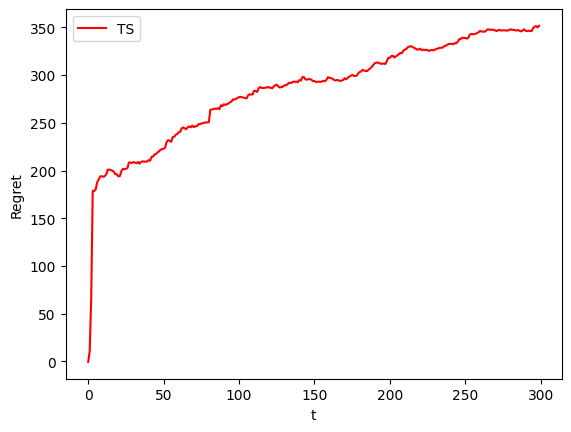

In [9]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

In [10]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(ts_rewards_per_experiment, axis=1)),np.std(np.sum(ts_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation considering", n_experiments,"experiments")
print(np.mean(np.sum(opt - ts_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ts_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ts_rewards_per_experiment, axis=0)), np.std(np.mean(ts_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ts_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ts_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 300 days and its standard deviation considering 5 experiments
35763.97251471675 39.60424127015712
-----------------------------------------------
Total expected regret over 300 days and its standard deviation considering 5 experiments
351.53470111624085 39.60424127015358
-----------------------------------------------
Average expected reward per round over 300 days and its standard deviation between the rounds considering 5 experiments
119.21324171572249 7.368035266594264
-----------------------------------------------
Average expected regret per round over 300 days and its standard deviation between the rounds considering 5 experiments
1.1717823370541365 7.368035266594265


Text(0.5, 1.0, 'Expected regret per round')

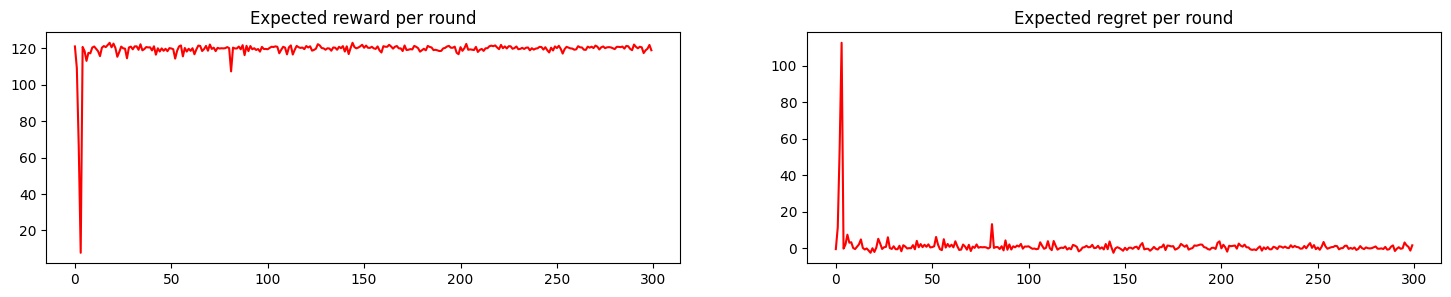

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ts_rewards_per_experiment, axis=0)), 'r')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ts_rewards_per_experiment, axis=0)), 'r')
ax[1].set_title("Expected regret per round")

In [12]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ts_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ts_learner.rewards_per_arm[i][0])-1,len(ts_learner.rewards_per_arm[i][1])-1,len(ts_learner.rewards_per_arm[i][2])-1,len(ts_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 7.20432941  6.84109749  1.98148649  0.        ]
 [ 5.39132586  5.26615452  0.95984     0.        ]
 [22.52707822 22.33065564  8.2782      0.        ]
 [45.20526054 40.20754655 20.54337063  0.        ]
 [39.84948035 34.67120835 23.998       0.        ]]
_______________________________________________
Pulls per arm for the last experiment
[262, 35, 2, 1]
[220, 77, 1, 2]
[154, 144, 1, 1]
[291, 6, 2, 1]
[293, 5, 1, 1]


In [13]:
from scipy.special import rel_entr
KL = sum(rel_entr([opt for i in range(n_days)],ts_rewards_per_day))
#KL divergence

In [14]:
KL = np.zeros(n_days)
for i in range(n_days):
    KL[i] = opt * np.log(opt/ts_rewards_per_day[i]) 

In [15]:
empiric_regret_ts = np.sum(opt-ts_rewards_per_day)
empiric_regret_ts

351.5347011162409

In [17]:
#Theoretical bounds for TS
delta_ts = opt - ts_rewards_per_day
UPPER_bound_regret_ts = (1+10)*np.log(ts_learner.t)+np.log(np.log(ts_learner.t))*np.sum(delta_ts/KL)
print("_______________________________________________")
print("Upper bound for the TS regret")
print(UPPER_bound_regret_ts)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print( empiric_regret_ts/UPPER_bound_regret_ts)


_______________________________________________
Upper bound for the TS regret
582.1553285718521
_______________________________________________
Ratio between empirical regret and upper bound for the regret
0.6038503537855241


## UCB: : optimization of the cumulative expected margin over all the products

In [18]:
#UCB
n_arms = 4
num_users = 100
n_days = 300
fixed_alpha = 1
fixed_weights = 1
fixed_units = 1
n_experiments = 10

ucb_rewards_per_experiment = []

ucb_rewards_per_day_per_experiment = []
ucb_rewards_per_day = np.zeros(n_days)

for e in range(n_experiments):

    env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha,fixed_weights, fixed_units)
    ucb_learner = UCB(n_arms=n_arms)

    for d in range(n_days):

        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        ucb_learner.update(pulled_arm, reward)
        ucb_rewards_per_day[d] += np.sum(reward)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

ucb_rewards_per_day = ucb_rewards_per_day/n_experiments

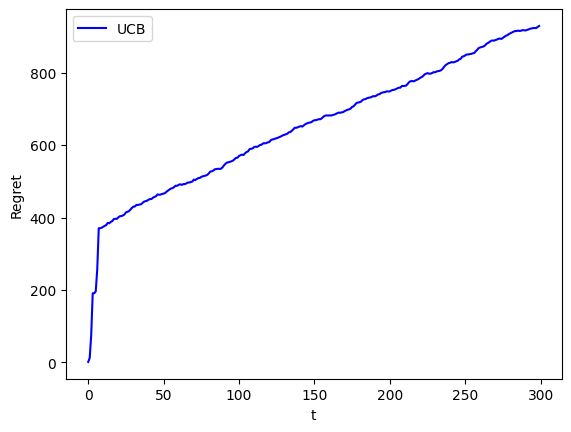

In [19]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis=0)), 'b')
plt.legend(["UCB"])
plt.show()

In [20]:
print("_______________________________________________")
print("Considering all the experiments:")
print("-----------------------------------------------")
print("Total expected reward over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(ucb_rewards_per_experiment, axis=1)),np.std(np.sum(ucb_rewards_per_experiment, axis = 1)))
print("-----------------------------------------------")
print("Total expected regret over",n_days, "days and its standard deviation between", n_experiments,"experiments")
print(np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1)), np.std(np.sum(opt - ucb_rewards_per_experiment, axis=1)))

print("-----------------------------------------------")
print("Average expected reward per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(ucb_rewards_per_experiment, axis=0)), np.std(np.mean(ucb_rewards_per_experiment, axis=0)))
print("-----------------------------------------------")
print("Average expected regret per round over",n_days, "days and its standard deviation between the rounds considering", n_experiments,"experiments")
print(np.mean(np.mean(opt-ucb_rewards_per_experiment, axis=0)), np.std(np.mean(opt-ucb_rewards_per_experiment, axis=0)))


_______________________________________________
Considering all the experiments:
-----------------------------------------------
Total expected reward over 300 days and its standard deviation between 10 experiments
35186.432345714864 124.88347538362605
-----------------------------------------------
Total expected regret over 300 days and its standard deviation between 10 experiments
929.0748701181334 124.88347538362827
-----------------------------------------------
Average expected reward per round over 300 days and its standard deviation between the rounds considering 10 experiments
117.28810781904953 10.491521202418479
-----------------------------------------------
Average expected regret per round over 300 days and its standard deviation between the rounds considering 10 experiments
3.0969162337271112 10.491521202418477


Text(0.5, 1.0, 'Expected regret per round')

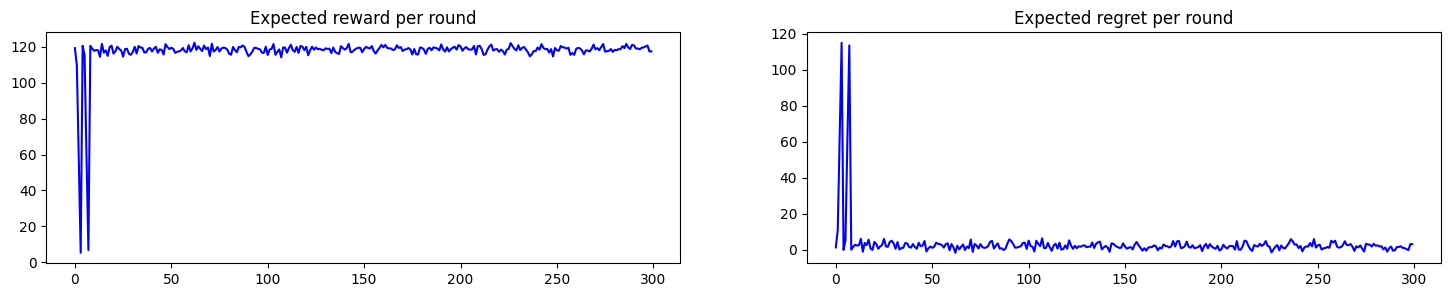

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,3))
ax[0].plot((np.mean(ucb_rewards_per_experiment, axis=0)), 'b')
ax[0].set_title("Expected reward per round")
ax[1].plot((np.mean(opt-ucb_rewards_per_experiment, axis=0)), 'b')
ax[1].set_title("Expected regret per round")

In [22]:
#Considering one experiment to have an idea about expected rewards per arm and number of pulls per arm
print("_______________________________________________")
print("Expected rewards per arm for the last experiment")    
print(ucb_learner.expected_rewards)
print("_______________________________________________")
print("Pulls per arm for the last experiment")
for i in range(5):
    pulls_per_arm = [len(ucb_learner.rewards_per_arm[i][0])-1,len(ucb_learner.rewards_per_arm[i][1])-1,len(ucb_learner.rewards_per_arm[i][2])-1,len(ucb_learner.rewards_per_arm[i][3])-1]

    print(pulls_per_arm)

print("_______________________________________________")
print("Upper confidence bounds for the last experiment")
print(ucb_learner.confidence)

_______________________________________________
Expected rewards per arm for the last experiment
[[ 7.20905739  6.82800939  3.39782818  0.        ]
 [ 5.38245369  5.09888402  1.52631562  0.        ]
 [22.59025692 22.25731627  8.44158553  1.32607895]
 [45.20161177 41.30595546 22.24488988  2.09968421]
 [39.84588965 36.68664452 25.22936583  1.52163043]]
_______________________________________________
Pulls per arm for the last experiment
[205, 89, 4, 2]
[204, 92, 2, 2]
[169, 127, 2, 2]
[232, 60, 6, 2]
[227, 62, 9, 2]
_______________________________________________
Upper confidence bounds for the last experiment
[[0.23582638 0.35801521 1.50542344 1.44202689]
 [0.23647291 0.35202654 1.39495883 1.44202689]
 [0.25973231 0.29970543 1.39495883 1.44202689]
 [0.22174431 0.4352616  1.3614553  1.44202689]
 [0.22417313 0.42805534 1.11464862 1.44202689]]


In [23]:
#Theoretical comparison (?)

opt_per_product = np.zeros(5)
delta_arms_per_product = np.zeros((5,4)) #differencees with the mean reward of the optimal arm
upper_bound_regret_per_product = np.zeros(5)
for i in range(5):
    opt_per_product[i] = np.max(margins_matrix[i,:] * conversion_rates[i])
    for j in range(4):
        delta_arms_per_product[i,j] = opt_per_product[i] - ucb_learner.expected_rewards[i,j]
        if delta_arms_per_product[i,j]>0:
            upper_bound_regret_per_product[i] += 4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j]
   

#R(UCB)<SUM(4*np.log(ucb_learner.t)/delta_arms_per_product[i,j] + 8*delta_arms_per_product[i,j])
print("Upper bound theoretical regret per product")
print(upper_bound_regret_per_product)
print("Ratio between empiric regret and the upper bound")
empiric_regret = np.mean(np.sum(opt - ucb_rewards_per_experiment, axis = 1))
print(empiric_regret/np.sum(upper_bound_regret_per_product))

Upper bound theoretical regret per product
[130.18235308 541.23539542  53.46813165 105.63430033 958.5558725 ]
Ratio between empiric regret and the upper bound
0.519304290373634


In [24]:
#Theoretical bounds for UCB
delta_ucb = opt - ucb_rewards_per_day
UPPER_bound_regret_ucb = 4*np.log(ucb_learner.t)*np.sum(1/delta_ucb+8*delta_ucb)
empiric_regret_ucb = np.sum(opt-ucb_rewards_per_day)
print("_______________________________________________")
print("Upper bound for the UCB regret")
print(UPPER_bound_regret_ucb)
# ratio empiric_regret/upper_bound
print("_______________________________________________")
print("Ratio between empirical regret and upper bound for the regret")
print( empiric_regret_ucb/UPPER_bound_regret_ucb)

_______________________________________________
Upper bound for the UCB regret
171596.59700454288
_______________________________________________
Ratio between empirical regret and upper bound for the regret
0.005414296590587613


Greedy Learner: each round chose the current best solution

In [41]:
# (INUTILE)
#Greedy Learner
n_arms = 4

num_users = 100
n_days = 1000
fixed_alpha = 1
fixed_weights = 1
margins_matrix = np.array([[2.,  5.,  8., 11.], [4.,  7., 10., 13.],[6.,  9., 12., 15.],[ 8., 11., 14., 17],[10., 13., 16., 19.]])

env = Environment(n_arms, E, margins_matrix, num_users, fixed_alpha, fixed_weights, fixed_units=1)
gr_learner = Greedy(n_arms=n_arms)

for d in range(n_days):
    
    pulled_arm = gr_learner.pull_arm(env.margins_matrix)
    reward = env.round(pulled_arm)
    gr_learner.update(pulled_arm, reward, env.clicks_current_day, env.purchases_current_day)

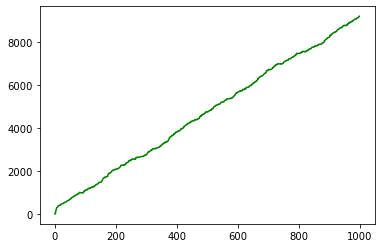

In [42]:
plt.plot(np.cumsum(opt-gr_learner.collected_rewards),'g')